# THUẬT PHÂN CỤM ĐA CẤP
## 3.2.3. Bài tập thực hành 1

Xây dựng mô hình phân cụm đa cấp trên tập dữ liệu chim cánh cụt. Dữ liệu lấy tại https://www.kaggle.com/code/youssefaboelwafa/clustering-penguins-species-k-means-clustering 

### Bước 1a: Install packages cần thiết (chỉ chạy lần duy nhất đầu tiên)

In [1]:
%pip install pandas matplotlib seaborn scipy scikit-learn numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Bước 1b: Import thư viện cần thiết

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
# Removed sklearn version check line

✅ All libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.3.1


### Bước 2: Tải và khám phá dữ liệu

In [3]:
# Load the dataset
# Download from: https://www.kaggle.com/code/youssefaboelwafa/clustering-penguins-species-k-means-clustering
url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv'
df = pd.read_csv(url)

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nStatistical summary:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (344, 8)

First few rows:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_

### Bước 3: Tiền xử lý dữ liệu

In [4]:
# Data preprocessing
# Remove rows with missing values
df_clean = df.dropna()

print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)}")

# Select numerical features for clustering
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df_clean[features]

print("\nFeatures selected for clustering:")
print(X.head())

# Save the species labels for later validation
true_labels = df_clean['species']

Original dataset size: 344
Cleaned dataset size: 333

Features selected for clustering:
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            39.5           17.4              186.0       3800.0
2            40.3           18.0              195.0       3250.0
4            36.7           19.3              193.0       3450.0
5            39.3           20.6              190.0       3650.0


### Bước 4: Chuẩn hóa dữ liệu

In [5]:
# Standardize the features (important for hierarchical clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

print("Scaled data statistics:")
print(X_scaled_df.describe())

Scaled data statistics:
       bill_length_mm  bill_depth_mm  flipper_length_mm   body_mass_g
count    3.330000e+02   3.330000e+02       3.330000e+02  3.330000e+02
mean    -1.024206e-15  -1.280257e-15       2.560514e-16 -1.280257e-16
std      1.001505e+00   1.001505e+00       1.001505e+00  1.001505e+00
min     -2.177987e+00  -2.067291e+00      -2.069852e+00 -1.874435e+00
25%     -8.227879e-01  -7.958519e-01      -7.836512e-01 -8.172292e-01
50%      9.288742e-02   6.872642e-02      -2.834620e-01 -1.953432e-01
75%      8.437412e-01   7.807321e-01       8.598276e-01  7.063915e-01
max      2.858227e+00   2.204743e+00       2.146028e+00  2.603144e+00


### Bước 5: Trực quan hóa dữ liệu ban đầu

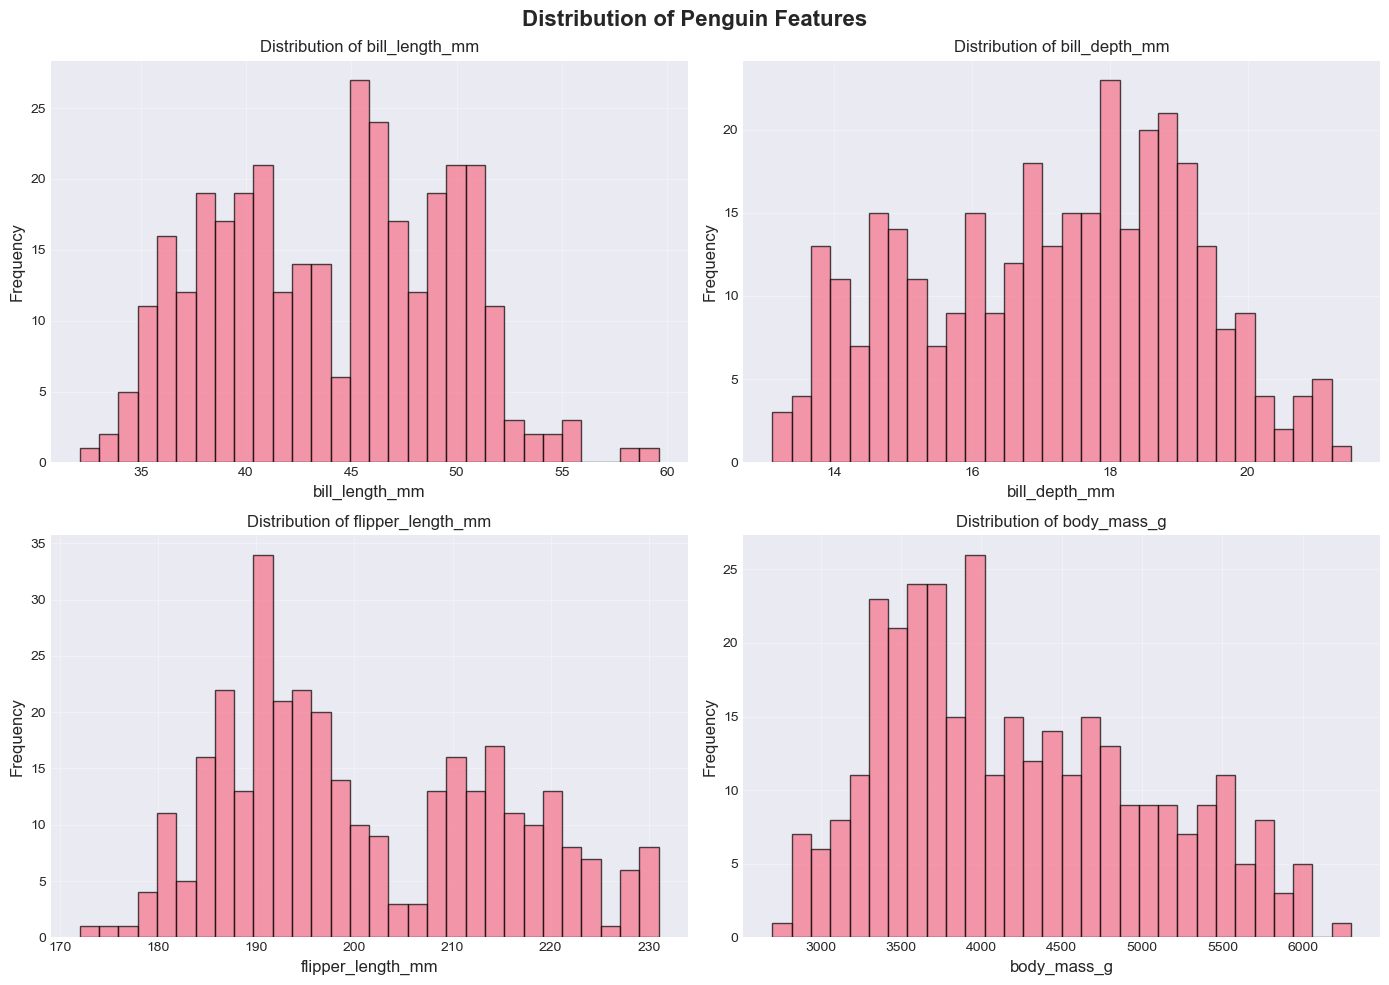

In [8]:
# Visualize the original data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Penguin Features', fontsize=16, fontweight='bold')

for idx, feature in enumerate(features):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(X[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Frequency', fontsize=12)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Bước 6: Tạo ma trận khoảng cách và dendogram

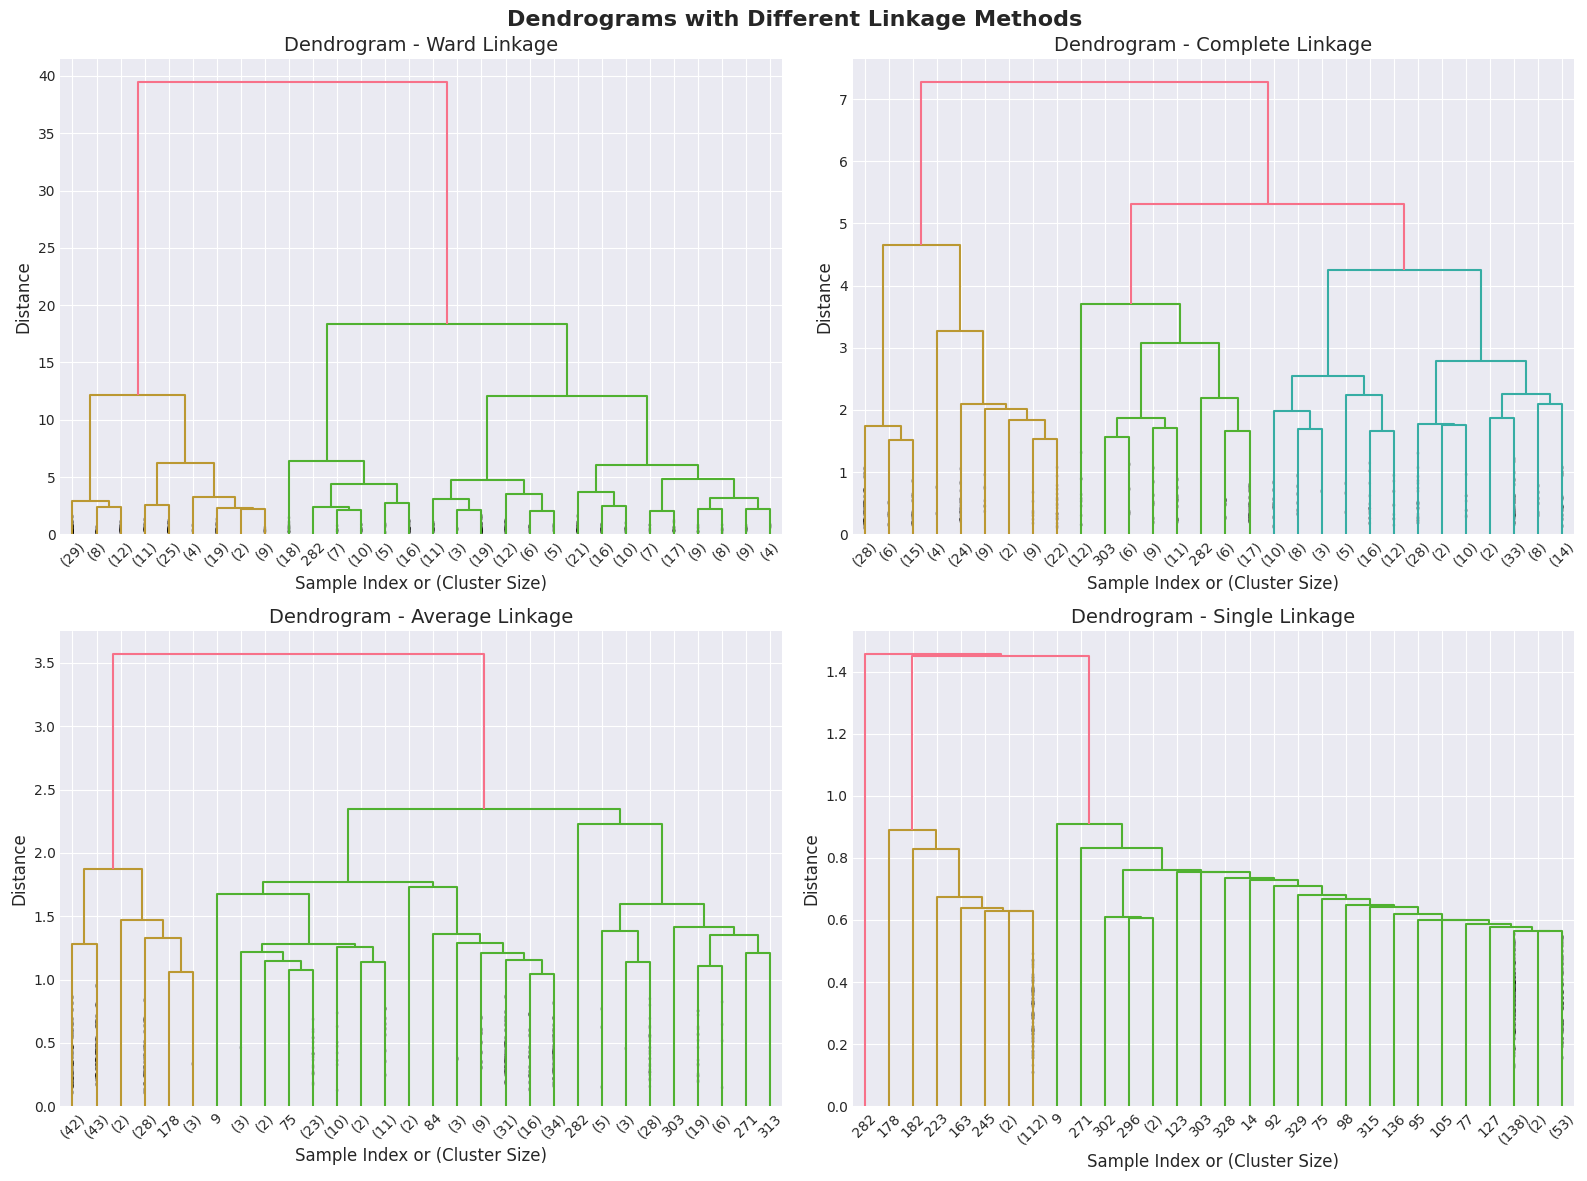

In [6]:
# Calculate linkage matrix using different methods
# Methods: 'single', 'complete', 'average', 'ward'
linkage_methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dendrograms with Different Linkage Methods', fontsize=16, fontweight='bold')

for idx, method in enumerate(linkage_methods):
    row = idx // 2
    col = idx % 2
    
    # Calculate linkage
    Z = linkage(X_scaled, method=method)
    
    # Plot dendrogram
    dendrogram(Z, ax=axes[row, col], truncate_mode='lastp', p=30, 
               leaf_font_size=10, show_contracted=True)
    axes[row, col].set_title(f'Dendrogram - {method.capitalize()} Linkage', fontsize=14)
    axes[row, col].set_xlabel('Sample Index or (Cluster Size)', fontsize=12)
    axes[row, col].set_ylabel('Distance', fontsize=12)

plt.tight_layout()
plt.show()

### Bước 7: Xác định số cụm tối ưu

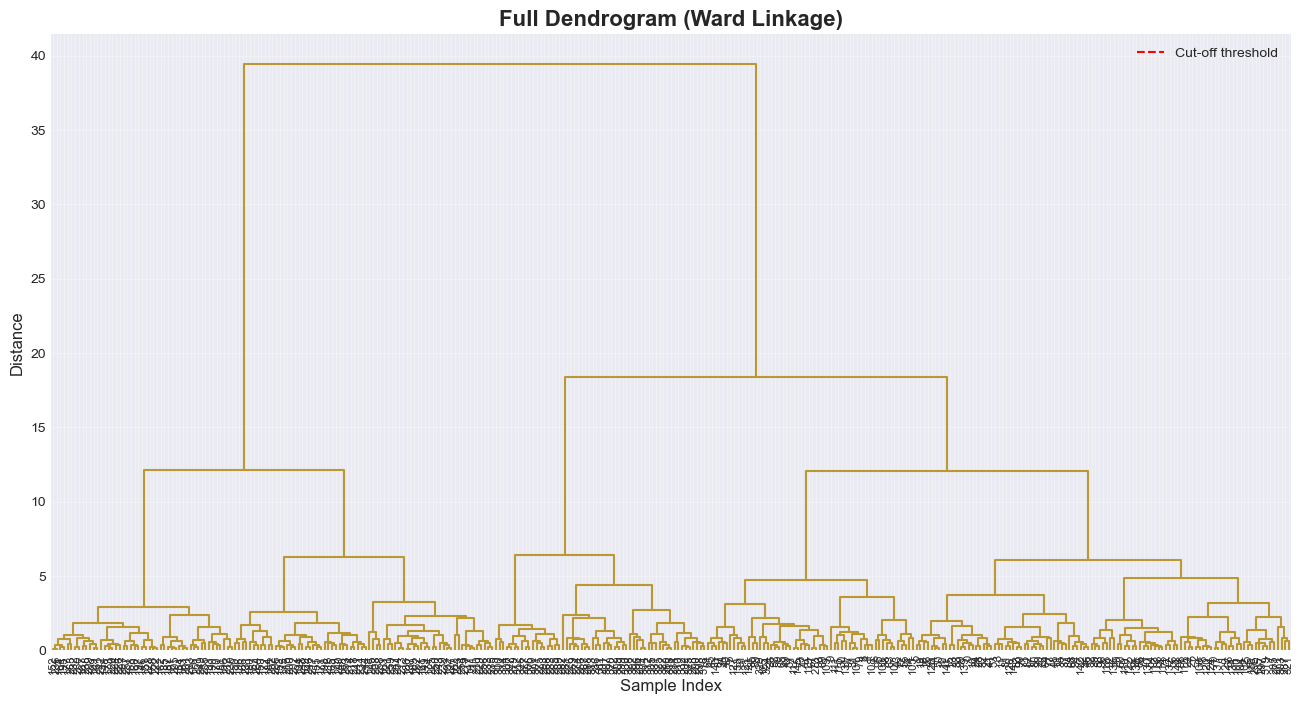

Based on the dendrogram, we can identify natural clusters.
A horizontal line can be drawn to determine the number of clusters.


In [10]:
# Plot dendrogram with larger size to determine optimal clusters
plt.figure(figsize=(16, 8))
Z = linkage(X_scaled, method='ward')

dendrogram(Z, 
           leaf_font_size=8,
           color_threshold=50)  # Adjust threshold to see clusters

plt.title('Full Dendrogram (Ward Linkage)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=50, color='r', linestyle='--', label='Cut-off threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Based on the dendrogram, we can identify natural clusters.")
print("A horizontal line can be drawn to determine the number of clusters.")

### Bước 8: Áp dụng Hierarchical Clustering với số cụm khác nhau

In [7]:
# Try different numbers of clusters
n_clusters_range = range(2, 7)

results = {}

for n_clusters in n_clusters_range:
    # Perform Agglomerative Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, 
                                          linkage='ward')
    clusters = hierarchical.fit_predict(X_scaled)
    
    results[n_clusters] = clusters
    
    # Add cluster labels to dataframe
    df_clean.loc[:, f'cluster_{n_clusters}'] = clusters
    
    print(f"\n{'='*50}")
    print(f"Number of clusters: {n_clusters}")
    print(f"{'='*50}")
    print(f"Cluster distribution:")
    print(pd.Series(clusters).value_counts().sort_index())


Number of clusters: 2
Cluster distribution:
0    214
1    119
Name: count, dtype: int64

Number of clusters: 3
Cluster distribution:
0    119
1    157
2     57
Name: count, dtype: int64

Number of clusters: 4
Cluster distribution:
0    157
1     70
2     57
3     49
Name: count, dtype: int64

Number of clusters: 5
Cluster distribution:
0     57
1     70
2    101
3     49
4     56
Name: count, dtype: int64

Number of clusters: 6
Cluster distribution:
0     70
1     56
2    101
3     49
4     39
5     18
Name: count, dtype: int64


### Bước 9: Trực quan hóa kết quả phân cụm

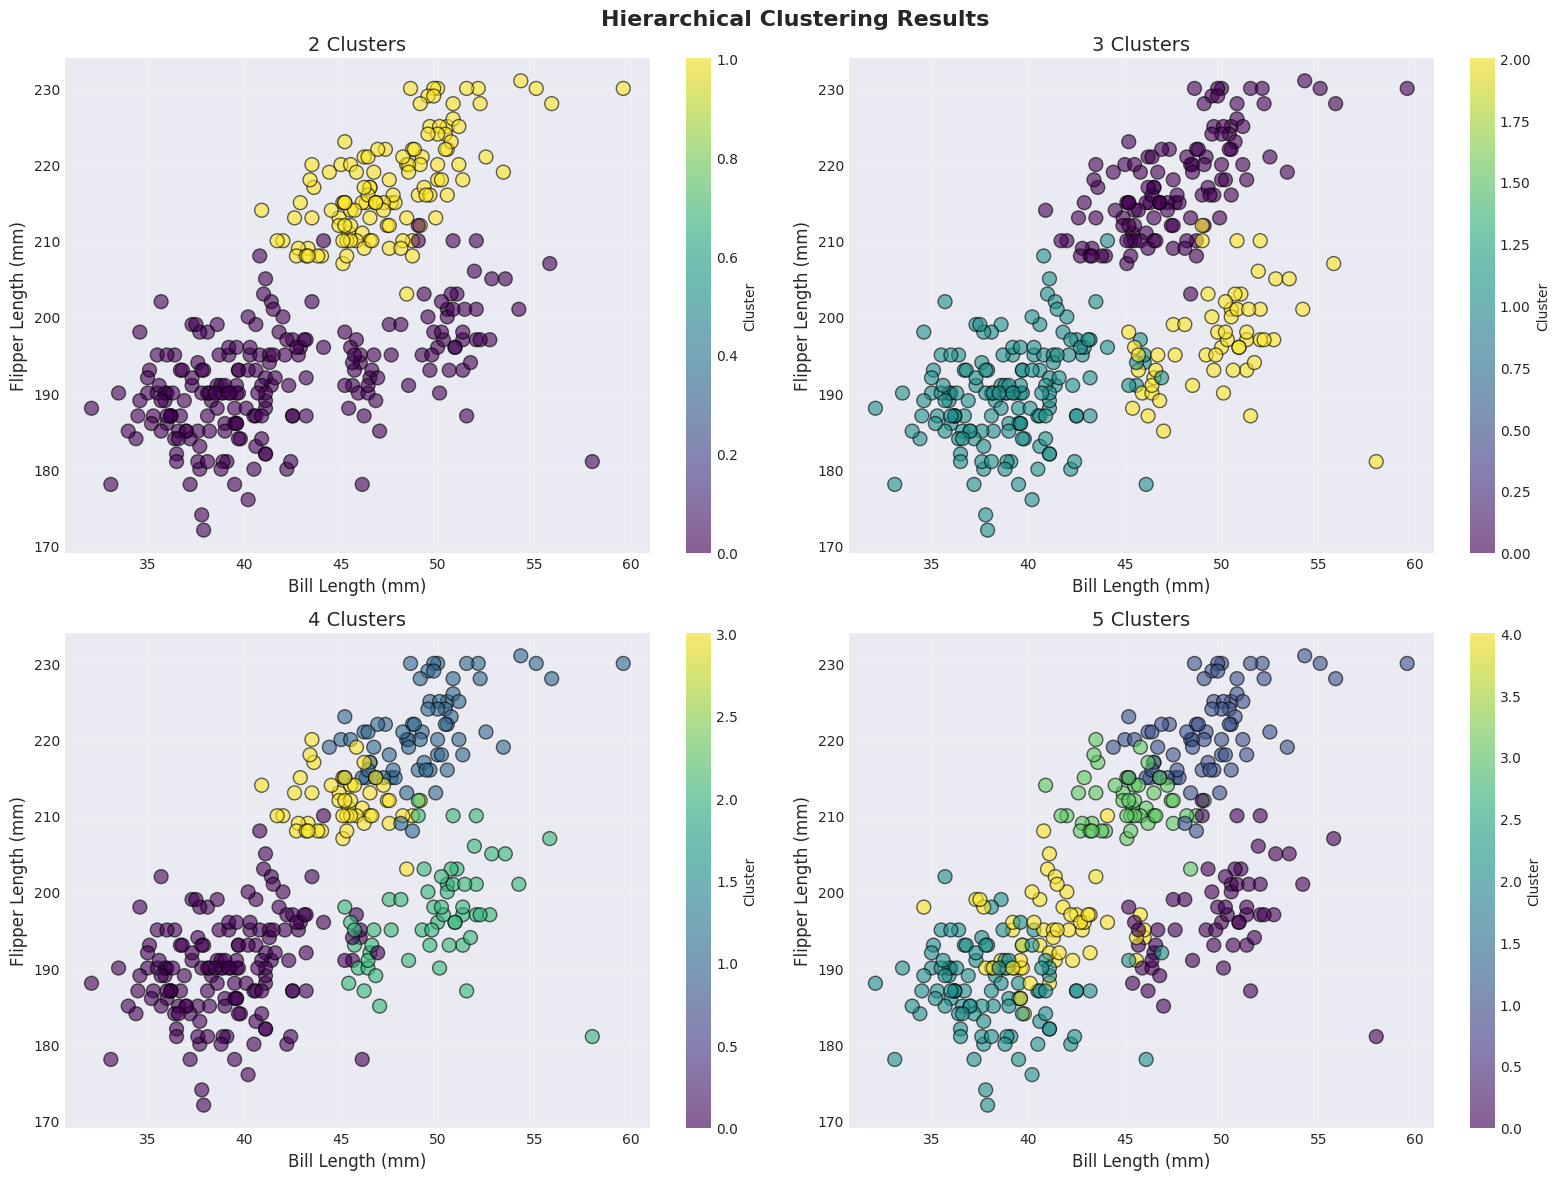

In [8]:
# Visualize clustering results for different numbers of clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hierarchical Clustering Results', fontsize=16, fontweight='bold')

cluster_configs = [2, 3, 4, 5]

for idx, n_clusters in enumerate(cluster_configs):
    row = idx // 2
    col = idx % 2
    
    # Use PCA or select two features for 2D visualization
    # Here we use bill_length_mm vs flipper_length_mm
    scatter = axes[row, col].scatter(X['bill_length_mm'], 
                                     X['flipper_length_mm'],
                                     c=results[n_clusters], 
                                     cmap='viridis',
                                     s=100, 
                                     alpha=0.6,
                                     edgecolors='black')
    
    axes[row, col].set_xlabel('Bill Length (mm)', fontsize=12)
    axes[row, col].set_ylabel('Flipper Length (mm)', fontsize=12)
    axes[row, col].set_title(f'{n_clusters} Clusters', fontsize=14)
    axes[row, col].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[row, col], label='Cluster')

plt.tight_layout()
plt.show()

### Bước 10: So sánh với nhãn thực tế

Cross-tabulation of Species vs Clusters:
Cluster      0    1   2
Species                
Adelie       0  146   0
Chinstrap    0   11  57
Gentoo     119    0   0


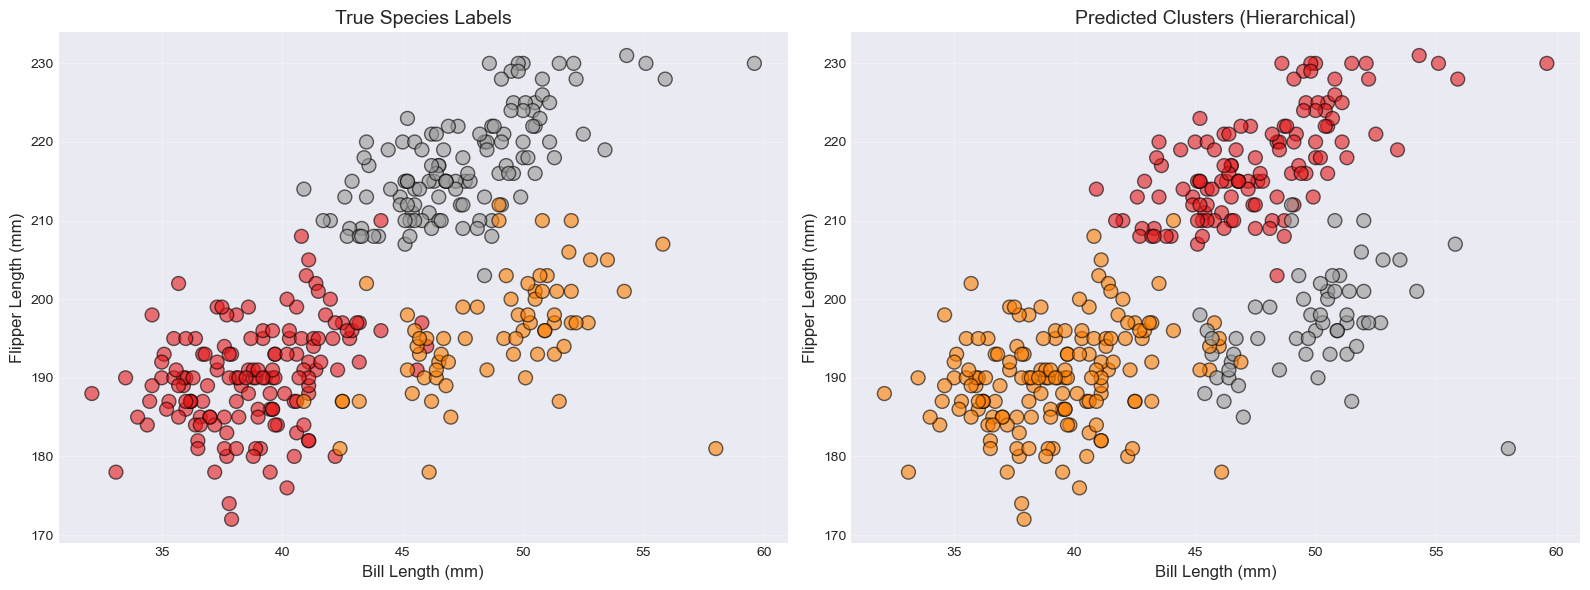

In [13]:
# Compare with actual species labels
# Assuming 3 clusters (as there are 3 penguin species)
n_clusters = 3
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_clusters = hierarchical.fit_predict(X_scaled)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Species': true_labels.values,
    'Cluster': predicted_clusters
})

# Cross-tabulation
print("Cross-tabulation of Species vs Clusters:")
print(pd.crosstab(comparison_df['Species'], comparison_df['Cluster']))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True species
scatter1 = axes[0].scatter(X['bill_length_mm'], 
                          X['flipper_length_mm'],
                          c=pd.Categorical(true_labels).codes,
                          cmap='Set1',
                          s=100,
                          alpha=0.6,
                          edgecolors='black')
axes[0].set_xlabel('Bill Length (mm)', fontsize=12)
axes[0].set_ylabel('Flipper Length (mm)', fontsize=12)
axes[0].set_title('True Species Labels', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Predicted clusters
scatter2 = axes[1].scatter(X['bill_length_mm'], 
                          X['flipper_length_mm'],
                          c=predicted_clusters,
                          cmap='Set1',
                          s=100,
                          alpha=0.6,
                          edgecolors='black')
axes[1].set_xlabel('Bill Length (mm)', fontsize=12)
axes[1].set_ylabel('Flipper Length (mm)', fontsize=12)
axes[1].set_title('Predicted Clusters (Hierarchical)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Bước 11: Đánh giá hiệu suất

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Evaluate clustering quality for different numbers of clusters
print("Clustering Quality Metrics")
print("="*70)
print(f"{'N Clusters':<12} {'Silhouette':<15} {'Davies-Bouldin':<20} {'Calinski-Harabasz':<20}")
print("="*70)

for n_clusters in range(2, 7):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = hierarchical.fit_predict(X_scaled)
    
    silhouette = silhouette_score(X_scaled, clusters)
    davies_bouldin = davies_bouldin_score(X_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(X_scaled, clusters)
    
    print(f"{n_clusters:<12} {silhouette:<15.4f} {davies_bouldin:<20.4f} {calinski_harabasz:<20.2f}")

print("="*70)
print("\nNote:")
print("- Silhouette Score: Higher is better (range: -1 to 1)")
print("- Davies-Bouldin Index: Lower is better")
print("- Calinski-Harabasz Score: Higher is better")

Clustering Quality Metrics
N Clusters   Silhouette      Davies-Bouldin       Calinski-Harabasz   
2            0.5308          0.7153               466.75              
3            0.4521          0.8502               408.22              
4            0.3981          0.8938               361.72              
5            0.3614          0.9977               379.29              
6            0.3317          0.9799               337.65              

Note:
- Silhouette Score: Higher is better (range: -1 to 1)
- Davies-Bouldin Index: Lower is better
- Calinski-Harabasz Score: Higher is better


### Bước 12: Trực quan hóa Silhouette Score

Average Silhouette Score: 0.4521


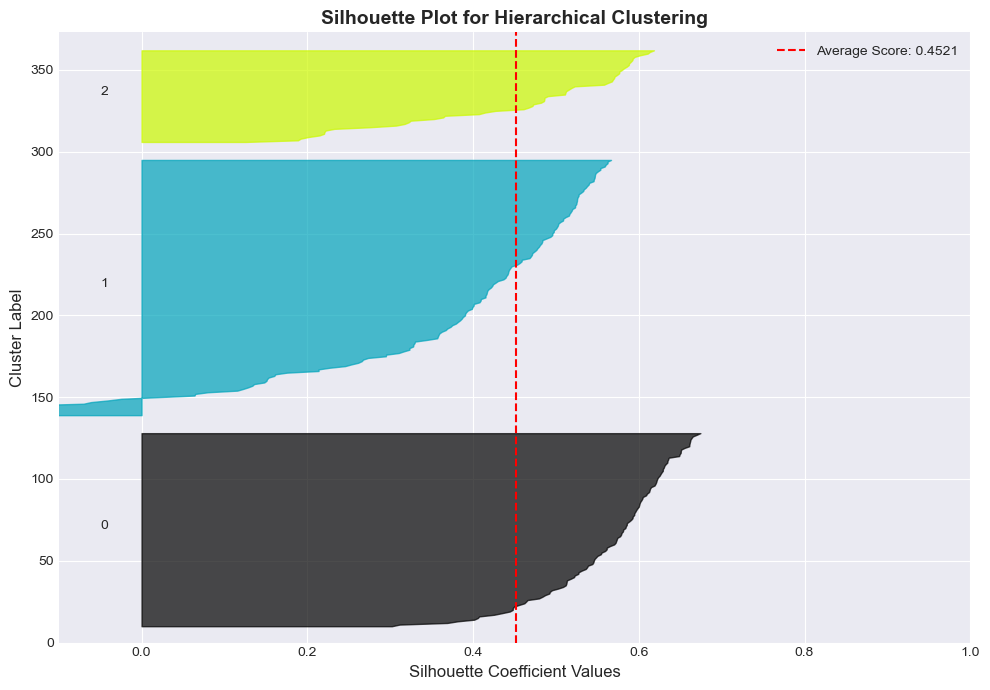

In [15]:
# Silhouette analysis
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

n_clusters = 3
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = hierarchical.fit_predict(X_scaled)

# Create a subplot with 1 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# The silhouette coefficient can range from -1, 1
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

# Compute the silhouette scores for each sample
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

print(f"Average Silhouette Score: {silhouette_avg:.4f}")

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot for Hierarchical Clustering', fontsize=14, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient Values', fontsize=12)
ax.set_ylabel('Cluster Label', fontsize=12)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
           label=f'Average Score: {silhouette_avg:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

### Bước 13: Phân tích đặc trưng của từng cụm

Cluster Characteristics (Mean Values):
               bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
Final_Cluster                                                               
0                   47.568067      14.996639         217.235294  5092.436975
1                   39.191720      18.286624         190.038217  3680.095541
2                   49.752632      18.601754         197.105263  3810.087719


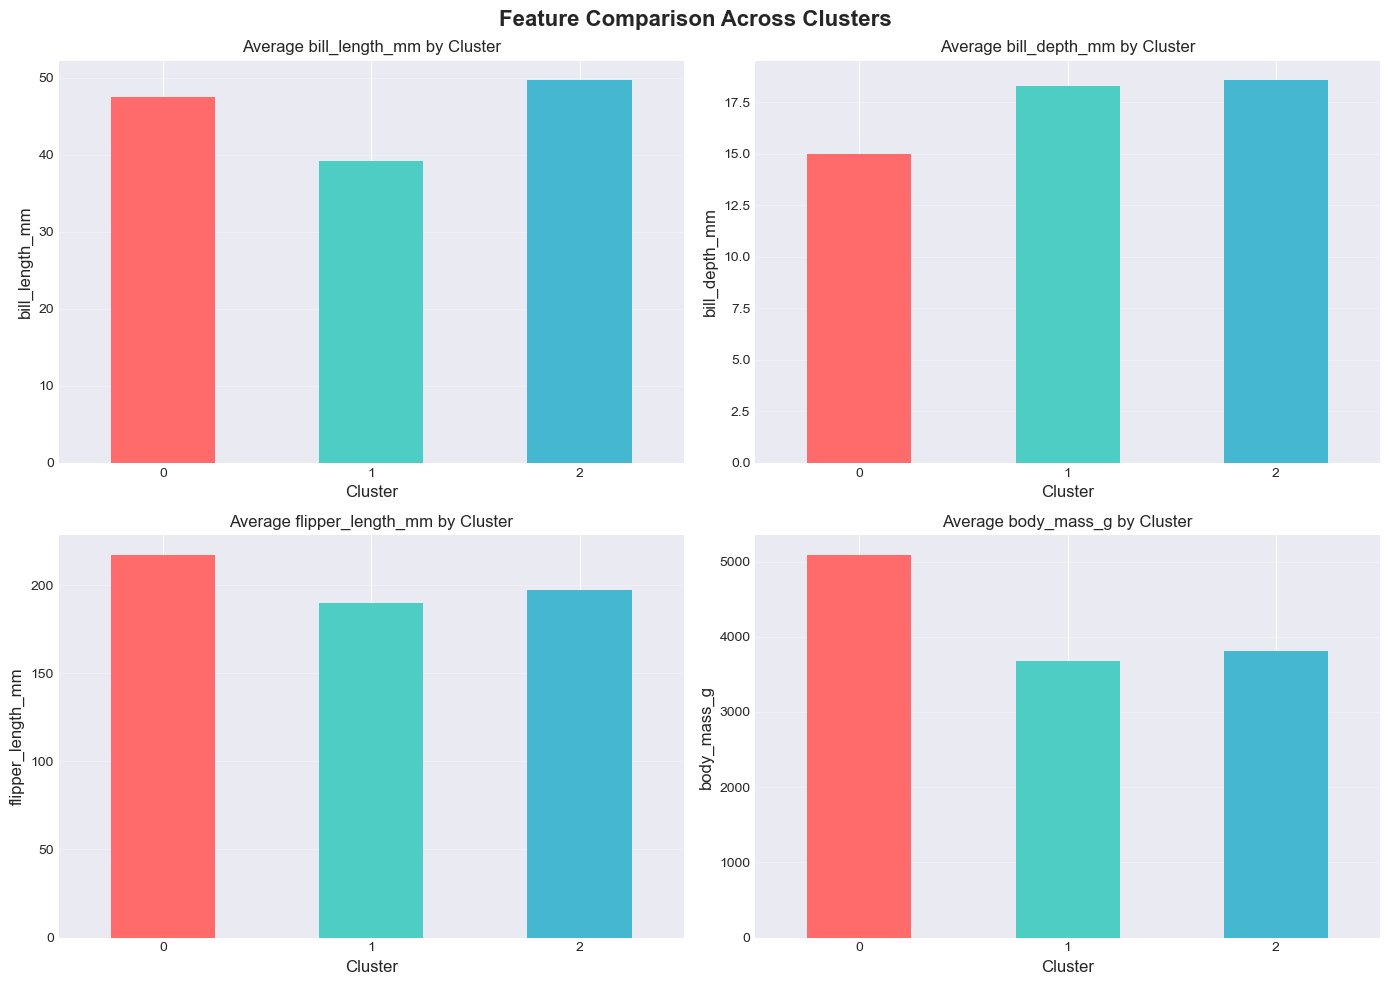


Species Distribution in Each Cluster:
species        Adelie  Chinstrap  Gentoo  All
Final_Cluster                                
0                   0          0     119  119
1                 146         11       0  157
2                   0         57       0   57
All               146         68     119  333


In [16]:
# Analyze characteristics of each cluster
n_clusters = 3
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_clean['Final_Cluster'] = hierarchical.fit_predict(X_scaled)

# Calculate mean values for each cluster
cluster_summary = df_clean.groupby('Final_Cluster')[features].mean()

print("Cluster Characteristics (Mean Values):")
print("="*80)
print(cluster_summary)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Comparison Across Clusters', fontsize=16, fontweight='bold')

for idx, feature in enumerate(features):
    row = idx // 2
    col = idx % 2
    
    cluster_summary[feature].plot(kind='bar', ax=axes[row, col], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[row, col].set_xlabel('Cluster', fontsize=12)
    axes[row, col].set_ylabel(feature, fontsize=12)
    axes[row, col].set_title(f'Average {feature} by Cluster', fontsize=12)
    axes[row, col].grid(True, alpha=0.3, axis='y')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Show species distribution in each cluster
print("\n" + "="*80)
print("Species Distribution in Each Cluster:")
print("="*80)
print(pd.crosstab(df_clean['Final_Cluster'], df_clean['species'], margins=True))

### Bước 14: Kết luận và lưu kết quả

In [17]:
# Save results to CSV
output_df = df_clean[['species', 'island', 'bill_length_mm', 'bill_depth_mm', 
                       'flipper_length_mm', 'body_mass_g', 'sex', 'Final_Cluster']]
output_df.to_csv('penguin_clustering_results.csv', index=False)

print("Results saved to 'penguin_clustering_results.csv'")

# Final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Total samples analyzed: {len(df_clean)}")
print(f"Number of clusters: {n_clusters}")
print(f"Features used: {', '.join(features)}")
print(f"Linkage method: Ward")
print(f"\nClustering successfully identified {n_clusters} distinct groups of penguins")
print("based on their physical characteristics.")

Results saved to 'penguin_clustering_results.csv'

FINAL SUMMARY
Total samples analyzed: 333
Number of clusters: 3
Features used: bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g
Linkage method: Ward

Clustering successfully identified 3 distinct groups of penguins
based on their physical characteristics.
